# Sentiment analysis with support vector machines

In this notebook, we will revisit a learning task that we encountered earlier in the course: predicting the *sentiment* (positive or negative) of a single sentence taken from a review of a movie, restaurant, or product. The data set consists of 3000 labeled sentences, which we divide into a training set of size 2500 and a test set of size 500. Previously we found a logistic regression classifier. Today we will use a support vector machine.

Before starting on this notebook, make sure the folder `sentiment_labelled_sentences` (containing the data file `full_set.txt`) is in the same directory. Recall that the data can be downloaded from https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences. 

## 1. Loading and preprocessing the data
 
Here we follow exactly the same steps as we did earlier.

In [12]:
%matplotlib inline
import string
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

## Read in the data set.
with open("sentiment_labelled_sentences/full_set.txt") as f:
    content = f.readlines()
    
## Remove leading and trailing white space
content = [x.strip() for x in content]

## Separate the sentences from the labels
sentences = [x.split("\t")[0] for x in content]
labels = [x.split("\t")[1] for x in content]

## Transform the labels from '0 v.s. 1' to '-1 v.s. 1'
y = np.array(labels, dtype='int8')
y = 2*y - 1

## full_remove takes a string x and a list of characters removal_list 
## returns x with all the characters in removal_list replaced by ' '
def full_remove(x, removal_list):
    for w in removal_list:
        x = x.replace(w, ' ')
    return x

## Remove digits
digits = [str(x) for x in range(10)]
digit_less = [full_remove(x, digits) for x in sentences]

## Remove punctuation
punc_less = [full_remove(x, list(string.punctuation)) for x in digit_less]

## Make everything lower-case
sents_lower = [x.lower() for x in punc_less]

## Define our stop words
stop_set = set(['the', 'a', 'an', 'i', 'he', 'she', 'they', 'to', 'of', 'it', 'from'])

## Remove stop words
sents_split = [x.split() for x in sents_lower]
sents_processed = [" ".join(list(filter(lambda a: a not in stop_set, x))) for x in sents_split]

## Transform to bag of words representation.
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, max_features = 4500)
data_features = vectorizer.fit_transform(sents_processed)

## Append '1' to the end of each vector.
data_mat = data_features.toarray()

## Split the data into testing and training sets
np.random.seed(0)
test_inds = np.append(np.random.choice((np.where(y==-1))[0], 250, replace=False), np.random.choice((np.where(y==1))[0], 250, replace=False))
train_inds = list(set(range(len(labels))) - set(test_inds))

train_data = data_mat[train_inds,]
train_labels = y[train_inds]

test_data = data_mat[test_inds,]
test_labels = y[test_inds]

print("train data: ", train_data.shape)
print("test data: ", test_data.shape)

train data:  (2500, 4500)
test data:  (500, 4500)


## 2. Fitting a support vector machine to the data

In support vector machines, we are given a set of examples $(x_1, y_1), \ldots, (x_n, y_n)$ and we want to find a weight vector $w \in \mathbb{R}^d$ that solves the following optimization problem:

$$ \min_{w \in \mathbb{R}^d} \| w \|^2 + C \sum_{i=1}^n \xi_i $$
$$ \text{subject to } y_i \langle w, x_i \rangle \geq 1 - \xi_i \text{ for all } i=1,\ldots, n$$

`scikit-learn` provides an SVM solver that we will use. The following routine takes as input the constant `C` (from the above optimization problem) and returns the training and test error of the resulting SVM model. It is invoked as follows:

* `training_error, test_error = fit_classifier(C)`

The default value for parameter `C` is 1.0.

In [14]:
from sklearn import svm
def fit_classifier(C_value=1.0):
    clf = svm.LinearSVC(C=C_value, loss='hinge')
    clf.fit(train_data,train_labels)
    ## Get predictions on training data
    train_preds = clf.predict(train_data)
    train_error = float(np.sum((train_preds > 0.0) != (train_labels > 0.0)))/len(train_labels)
    ## Get predictions on test data
    test_preds = clf.predict(test_data)
    test_error = float(np.sum((test_preds > 0.0) != (test_labels > 0.0)))/len(test_labels)
    ##
    return train_error, test_error

In [15]:
cvals = [0.01,0.1,1.0,10.0,100.0,1000.0,10000.0]
for c in cvals:
    train_error, test_error = fit_classifier(c)
    print ("Error rate for C = %0.2f: train %0.3f test %0.3f" % (c, train_error, test_error))

Error rate for C = 0.01: train 0.215 test 0.250
Error rate for C = 0.10: train 0.074 test 0.174
Error rate for C = 1.00: train 0.011 test 0.152
Error rate for C = 10.00: train 0.002 test 0.188
Error rate for C = 100.00: train 0.002 test 0.200
Error rate for C = 1000.00: train 0.004 test 0.214
Error rate for C = 10000.00: train 0.002 test 0.202


/home/kamil/anaconda3/envs/ml-fundamentals-edx/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/kamil/anaconda3/envs/ml-fundamentals-edx/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/kamil/anaconda3/envs/ml-fundamentals-edx/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/kamil/anaconda3/envs/ml-fundamentals-edx/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## 3. Evaluating C by k-fold cross-validation

As we can see, the choice of `C` has a very significant effect on the performance of the SVM classifier. We were able to assess this because we have a separate test set. In general, however, this is a luxury we won't possess. How can we choose `C` based only on the training set?

A reasonable way to estimate the error associated with a specific value of `C` is by **`k-fold cross validation`**:
* Partition the training set `S` into `k` equal-sized sized subsets `S_1, S_2, ..., S_k`.
* For `i=1,2,...,k`, train a classifier with parameter `C` on `S - S_i` (all the training data except `S_i`) and test it on `S_i` to get error estimate `e_i`.
* Average the errors: `(e_1 + ... + e_k)/k`

The following procedure, **cross_validation_error**, does exactly this. It takes as input:
* the training set `x,y`
* the value of `C` to be evaluated
* the integer `k`

and it returns the estimated error of the classifier for that particular setting of `C`. <font color="magenta">Look over the code carefully to understand exactly what it is doing.</font>

In [16]:
def cross_validation_error(x,y,C_value,k):
    n = len(y)
    ## Randomly shuffle indices
    indices = np.random.permutation(n)
    
    ## Initialize error
    err = 0.0
    
    ## Iterate over partitions
    for i in range(k):
        ## Partition indices
        test_indices = indices[int(i*(n/k)):int((i+1)*(n/k) - 1)]
        train_indices = np.setdiff1d(indices, test_indices)
        
        ## Train classifier with parameter c
        clf = svm.LinearSVC(C=C_value, loss='hinge')
        clf.fit(x[train_indices], y[train_indices])
        
        ## Get predictions on test partition
        preds = clf.predict(x[test_indices])
        
        ## Compute error
        err += float(np.sum((preds > 0.0) != (y[test_indices] > 0.0)))/len(test_indices)
        
    return err/k

## 4. Picking a value of C

The procedure **cross_validation_error** (above) evaluates a single candidate value of `C`. We need to use it repeatedly to identify a good `C`. 

<font color="magenta">**For you to do:**</font> Write a function to choose `C`. It will be invoked as follows:

* `c, err = choose_parameter(x,y,k)`

where
* `x,y` is the training data
* `k` is the number of folds of cross-validation
* `c` is chosen value of the parameter `C`
* `err` is the cross-validation error estimate at `c`

<font color="magenta">Note:</font> This is a tricky business because a priori, even the order of magnitude of `C` is unknown. Should it be 0.0001 or 10000? You might want to think about trying multiple values that are arranged in a geometric progression (such as powers of ten). *In addition to returning a specific value of `C`, your function should **plot** the cross-validation errors for all the values of `C` it tried out (possibly using a log-scale for the `C`-axis).*

In [17]:

def choose_parameter(x,y,k):
    cs = 10.0 ** np.arange(-4, 5)
    errors = []
    for c in cs:
        errors.append(cross_validation_error(x, y, c, k))

    plt.plot(cs, errors)
    plt.ylabel('Error rate', fontsize=14)
    plt.xlabel('C', fontsize=14)
    plt.xscale('log')
    plt.show()


    min_arg = np.argmin(errors)
    return cs[min_arg], errors[min_arg]



Now let's try out your routine!

/home/kamil/anaconda3/envs/ml-fundamentals-edx/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/kamil/anaconda3/envs/ml-fundamentals-edx/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/kamil/anaconda3/envs/ml-fundamentals-edx/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/kamil/anaconda3/envs/ml-fundamentals-edx/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/kamil/anaconda3/envs/ml-fundamentals-edx/lib/p

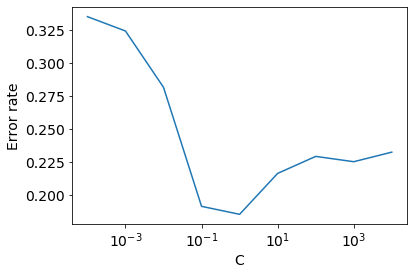

Choice of C:  1.0
Cross-validation error estimate:  0.18554216867469878
Test error:  0.152


In [18]:
c, err = choose_parameter(train_data, train_labels, 10)
print("Choice of C: ", c)
print("Cross-validation error estimate: ", err)
## Train it and test it
clf = svm.LinearSVC(C=c, loss='hinge')
clf.fit(train_data, train_labels)
preds = clf.predict(test_data)
error = float(np.sum((preds > 0.0) != (test_labels > 0.0)))/len(test_labels)
print("Test error: ", error)

<font color="magenta">**For you to ponder:**</font> How does the plot of cross-validation errors for different `C` look? Is there clearly a trough in which the returned value of `C` falls? Does the plot provide some reassurance that the choice is reasonable?